# Проект финальный: вариант 3

#### Проект: вариант 3
Представьте, что вы работаете в крупном дейтинговом приложении.

Помимо базовых функций, в приложении также имеется премиум-подписка, которая дает доступ к ряду важных дополнительных возможностей. Был проведен A/B тест, в рамках которого для новых пользователей из нескольких стран была изменена стоимость премиум-подписки* при покупке через две новые платежные системы. При этом стоимость пробного периода оставалась прежней.

Проверьте:

Был ли эксперимент успешен в целом.
Проанализируйте, имеет ли нововведение смысл среди каких-либо конкретных групп пользователей.
*Деньги за подписку списываются ежемесячно до тех пор, пока пользователь её не отменит.

  

Данные
Всего есть три группы: тестовая (test), контрольная 1 (control_1) и контрольная 2 (control_2). Для каждой из них:

users_*.csv – информация о пользователях:

uid – идентификатор пользователя
age – возраст
attraction_coeff – коэффициент привлекательности (от 0 до 1000, \frac{лайки}{просмотры}*1000 
просмотры
лайки
​
 ∗1000)
coins – число монеток (внутренняя валюта)
country – страна  
visit_days – в какие дни после регистрации пользователь посещал приложение (напр. в 1, затем в 7)
gender – пол
age_filter_start  – фильтр поиска, мин. значение 
age_filter_end  – фильтр поиска, макс. значение 
views_count – число полученных оценок 
was_premium – был ли когда-либо премиум (либо пробный период премиум-статуса, либо купленный за деньги)
is_premium –  является ли премиум
total_revenue – нормированная выручка
 
transactions_*.csv – информация о платежах пользователей:

uid – идентификатор пользователя
country – страна
joined_at – дата и время регистрации
paid_at – дата и время покупки
revenue – нормированная выручка
payment_id – идентификатор платежа
from_page – откуда пользователь перешел на страницу оплаты
product_type – тип продукта (trial_premium – пробная премиум-подписка, premium_no_trial – премиум-подписка без пробной, coins – подписка за внутреннюю валюту, other_type – другое)
 
Файлы:

users_test – информация о пользователях в тестовой группе. 
users_control_1 – информация о пользователях в первой контрольной группе. 
users_control_2 – информация о пользователях во второй контрольной группе . 
transactions_test – информация о платежах пользователей в тестовой группе. 
transactions_control_1 – информация о платежах пользователей в первой контрольной группе. 
transactions_control_2 – информация о платежах пользователей во второй контрольной группе 

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns
import scipy.stats as stats
from scipy.stats import chi2_contingency, norm, shapiro
from tqdm.auto import tqdm
from urllib.parse import urlencode

### Импортируем и проверяем данные

In [2]:
# Function to get df by Link from Yandex Disk
def get_ya_disk_df(url, sep):
    
    start_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    full_url = start_url + urlencode(dict(public_key=url))
    request = requests.get(full_url)
    final_url = json.loads(request.text)['href']
    
    df = pd.read_csv(final_url, sep=sep)
    return df

In [3]:
# Загружаем файлы при помощи созданной функции
users_test = get_ya_disk_df("https://disk.yandex.ru/d/L8HxRYDn2l4h9A", sep=';')
users_control_1 = get_ya_disk_df("https://disk.yandex.ru/d/TxOD_JxnkMd4mA", sep=';')
users_control_2 = get_ya_disk_df("https://disk.yandex.ru/d/YT6OWRK2cTWfLg", sep=';')
transactions_test  = get_ya_disk_df("https://disk.yandex.ru/d/3viYBnm7cyihkQ", sep=';')
transactions_control_1  = get_ya_disk_df("https://disk.yandex.ru/d/84jzzJeQ4tqVyg", sep=';')
transactions_control_2  = get_ya_disk_df("https://disk.yandex.ru/d/_pOo7mrDCZZMyA", sep=';')

In [4]:
users_test.head(2)

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
0,892309896,27,685,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,16,17",1,24,30,89,NaN,NaN,0
1,892044516,27,0,NaN,Germany,NaN,1,24,30,0,NaN,NaN,0


In [5]:
users_test.drop_duplicates(inplace=True)
users_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4308 entries, 0 to 4307
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   uid               4308 non-null   int64  
 1   age               4308 non-null   int64  
 2   attraction_coeff  4308 non-null   int64  
 3   coins             49 non-null     float64
 4   country           4308 non-null   object 
 5   visit_days        2978 non-null   object 
 6   gender            4308 non-null   int64  
 7   age_filter_start  4308 non-null   int64  
 8   age_filter_end    4308 non-null   int64  
 9   views_count       4308 non-null   int64  
 10  was_premium       408 non-null    float64
 11  is_premium        157 non-null    float64
 12  total_revenue     4308 non-null   int64  
dtypes: float64(3), int64(8), object(2)
memory usage: 471.2+ KB


In [6]:
users_control_1.head(2)

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
0,892319115,25,435,NaN,United States of America,"1,2,3,4,5,6",0,22,32,982,NaN,NaN,0
1,891248523,29,500,NaN,United States of America,"1,2",1,26,32,12,NaN,NaN,0


In [7]:
users_control_1.drop_duplicates(inplace=True)
users_control_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4340 entries, 0 to 4339
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   uid               4340 non-null   int64  
 1   age               4340 non-null   int64  
 2   attraction_coeff  4340 non-null   int64  
 3   coins             60 non-null     float64
 4   country           4340 non-null   object 
 5   visit_days        3016 non-null   object 
 6   gender            4340 non-null   int64  
 7   age_filter_start  4340 non-null   int64  
 8   age_filter_end    4340 non-null   int64  
 9   views_count       4340 non-null   int64  
 10  was_premium       436 non-null    float64
 11  is_premium        192 non-null    float64
 12  total_revenue     4340 non-null   int64  
dtypes: float64(3), int64(8), object(2)
memory usage: 474.7+ KB


In [8]:
users_control_2.drop_duplicates(inplace=True)
users_control_2.head(2)

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
0,892035504,37,137,NaN,Israel,"1,2,3,4,5,6,7,8,9,11,13",1,30,40,51,NaN,NaN,0
1,891782112,57,0,NaN,Italy,1,1,54,60,0,NaN,NaN,0


In [9]:
users_control_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4264 entries, 0 to 4263
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   uid               4264 non-null   int64  
 1   age               4264 non-null   int64  
 2   attraction_coeff  4264 non-null   int64  
 3   coins             61 non-null     float64
 4   country           4264 non-null   object 
 5   visit_days        2900 non-null   object 
 6   gender            4264 non-null   int64  
 7   age_filter_start  4264 non-null   int64  
 8   age_filter_end    4264 non-null   int64  
 9   views_count       4264 non-null   int64  
 10  was_premium       411 non-null    float64
 11  is_premium        191 non-null    float64
 12  total_revenue     4264 non-null   int64  
dtypes: float64(3), int64(8), object(2)
memory usage: 466.4+ KB


In [10]:
transactions_test.head(2)

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,891345942,Italy,2017-05-11 13:00:00,2017-11-13 15:04:00,12909,147,trial_vip_popup,trial_premium
1,892054251,United States of America,2017-10-22 00:33:00,2017-10-30 01:37:00,13923,147,trial_vip_popup,trial_premium


In [11]:
transactions_test.drop_duplicates(inplace=True)
transactions_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 266 entries, 0 to 272
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   uid           266 non-null    int64 
 1   country       266 non-null    object
 2   joined_at     266 non-null    object
 3   paid_at       266 non-null    object
 4   revenue       266 non-null    int64 
 5   payment_id    266 non-null    int64 
 6   from_page     266 non-null    object
 7   product_type  266 non-null    object
dtypes: int64(3), object(5)
memory usage: 18.7+ KB


In [12]:
transactions_control_1.head(2)

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,891319275.0,France,2017-05-11 19:57:00,2017-12-11 21:57:00,12727.0,147.0,trial_vip_popup,trial_premium
1,892421826.0,Israel,2017-10-14 12:46:00,2017-10-23 12:54:00,14586.0,147.0,trial_vip_popup,trial_premium


In [13]:
transactions_control_1.drop_duplicates(inplace=True)
transactions_control_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 357 entries, 0 to 377
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   uid           356 non-null    float64
 1   country       356 non-null    object 
 2   joined_at     357 non-null    object 
 3   paid_at       357 non-null    object 
 4   revenue       356 non-null    float64
 5   payment_id    356 non-null    float64
 6   from_page     356 non-null    object 
 7   product_type  356 non-null    object 
dtypes: float64(3), object(5)
memory usage: 25.1+ KB


In [14]:
transactions_control_2.head(2)

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,891266616,Argentina,2017-06-11 15:25:00,2017-10-11 17:35:00,6305,19,autorefill,coins
1,892186737,Chile,2017-10-19 06:03:00,2017-04-11 08:53:00,4732,147,promo_09,premium_no_trial


In [15]:
transactions_control_2.drop_duplicates(inplace=True)
transactions_control_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 323 entries, 0 to 327
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   uid           323 non-null    int64 
 1   country       323 non-null    object
 2   joined_at     323 non-null    object
 3   paid_at       323 non-null    object
 4   revenue       323 non-null    int64 
 5   payment_id    323 non-null    int64 
 6   from_page     323 non-null    object
 7   product_type  323 non-null    object
dtypes: int64(3), object(5)
memory usage: 22.7+ KB


Дубликаты удалили.
Трансформируем отдельные поля данных в дату

In [16]:
transactions_test.joined_at = pd.to_datetime(transactions_test.joined_at)
transactions_test.paid_at = pd.to_datetime(transactions_test.paid_at)
transactions_control_1.joined_at = pd.to_datetime(transactions_control_1.joined_at)
transactions_control_1.paid_at = pd.to_datetime(transactions_control_1.paid_at)
transactions_control_2.joined_at = pd.to_datetime(transactions_control_2.joined_at)
transactions_control_2.paid_at = pd.to_datetime(transactions_control_2.paid_at)

Проверим, чтобы периоды времены в тестовой и контрольных группах быди одинаковы.

In [17]:
transactions_test['paid_at'].min()

Timestamp('2017-01-11 04:37:00')

In [18]:
transactions_control_1['paid_at'].min()

Timestamp('2016-12-14 16:16:00')

In [19]:
transactions_control_2['paid_at'].min()

Timestamp('2017-01-11 05:34:00')

Некорректно отобрана контрольная группа №1 - есть транзакции ранее старта теста.
Такие данные следует удалить.

In [20]:
transactions_control_1 = transactions_control_1.query(' paid_at >= "2017-01-11 00:00:00" ')

Проверим данные на наличие выбросов на диаграмме "ящик с усами"

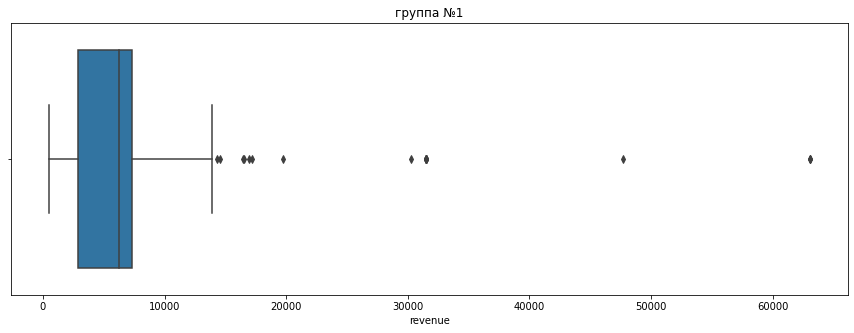

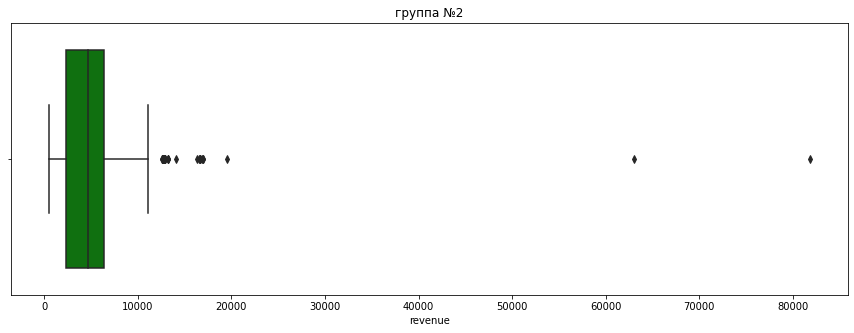

In [21]:
plt.figure(figsize=(15,5))
plt.title("группа №1")
sns.boxplot(x=transactions_control_1['revenue'])
plt.show()

plt.figure(figsize=(15,5))
plt.title("группа №2")
sns.boxplot(x=transactions_control_2['revenue'], color = 'green')
plt.show()

Выбросы есть. Посмотрим на квантили

In [22]:
transactions_control_2['revenue'].describe()
transactions_control_1['revenue'].describe()

count      353.000000
mean      7065.150142
std       7995.542549
min        481.000000
25%       2886.000000
50%       6292.000000
75%       7332.000000
max      63037.000000
Name: revenue, dtype: float64

Отсечем аномально высокие значения на уровне 13000 (чисто визуально) 

In [23]:
transactions_control_1 = transactions_control_1.query(' revenue < 13000 ')
transactions_control_2 = transactions_control_2.query(' revenue < 13000 ')

Можно приступать к тестированию системы сплитования по полю Выручка (код взят из урока)

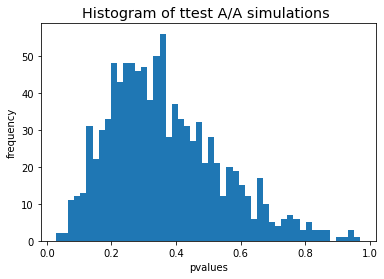

0.002

In [24]:
n = 100000
simulations = 1000
n_s = 280
res = []

for i in tqdm(range(simulations)):
    s1 = transactions_control_1['revenue'].sample(n_s, replace = False).values
    s2 = transactions_control_2['revenue'].sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1])

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# FPR не сойдется
sum(np.array(res) <0.05) / simulations

### Тест пройден, сплитование выровнено. 

Начнем А/B тест и проверим метрику APRU, которая, как мне кажется, лучше отражает цель эксперимента - увеличение доходности.

 Объединяем файлы с информацией о принадлежности пользователя к контрольной или экспериментальной группе и добавим новое поле "group" (А1 и A2– контрольная №1 и №2 , B – целевая группа)

In [25]:
transactions_test['group'] = "B"
transactions_control_1['group'] = "A1"
transactions_control_2['group'] = "A2"
all_group = pd.concat([transactions_test, transactions_control_1, transactions_control_2], ignore_index=True)
all_group.head(5)

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,group
0,891345942.0,Italy,2017-05-11 13:00:00,2017-11-13 15:04:00,12909.0,147.0,trial_vip_popup,trial_premium,B
1,892054251.0,United States of America,2017-10-22 00:33:00,2017-10-30 01:37:00,13923.0,147.0,trial_vip_popup,trial_premium,B
2,892236423.0,United States of America,2017-10-18 01:09:00,2017-10-23 00:15:00,3783.0,67.0,menu,other_type,B
3,892236423.0,United States of America,2017-10-18 01:09:00,2017-10-27 22:38:00,3783.0,67.0,menu,other_type,B
4,892168170.0,United States of America,2017-10-19 17:10:00,2017-10-27 19:10:00,9087.0,147.0,trial_vip_popup,trial_premium,B


In [26]:
all_group.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 896 entries, 0 to 895
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   uid           896 non-null    float64       
 1   country       896 non-null    object        
 2   joined_at     896 non-null    datetime64[ns]
 3   paid_at       896 non-null    datetime64[ns]
 4   revenue       896 non-null    float64       
 5   payment_id    896 non-null    float64       
 6   from_page     896 non-null    object        
 7   product_type  896 non-null    object        
 8   group         896 non-null    object        
dtypes: datetime64[ns](2), float64(3), object(4)
memory usage: 63.1+ KB


   
Рассчитаем следующие метрики в обеих групп:  
* число уникальных участников,     
* число покупок,      
* сумму оплат,      
* средний чек,      
* минимальную и максимальную сумму оплаты,          
* ARPU

In [27]:
metrics = all_group\
    .groupby(['group'], as_index=False)\
    .agg({'revenue': ['count', 'sum', 'mean', 'min', 'max'], 'uid': 'nunique'})\
    .round(0)
metrics['ARPU'] = metrics['revenue']['sum'].div(metrics['uid']['nunique']).round(0)
metrics

group revenue                                         uid     ARPU
          count        sum    mean    min       max nunique         
0    A1     323  1706809.0  5284.0  481.0   12909.0     175   9753.0
1    A2     307  1539707.0  5015.0  481.0   12935.0     175   8798.0
2     B     266  2332226.0  8768.0  533.0  113477.0     146  15974.0

##### ВЫВОД - Очевидно, что пользователи, которым была предложена новая механика оплаты, в среднем обеспечили больший доход. Оценим статистическую значимость полученных разниц.

Преобразуем данные и выполним статистическое тестирование. 
Примем p - value на уровне 0,05 достаточным для отклонения нулевой гипотезы.

In [28]:
all_group['revenue'] = all_group['revenue'].fillna(0)

A1 = all_group.query('group == "A1" and revenue > 0')
A2 = all_group.query('group == "A2" and revenue > 0')
B = all_group.query('group == "B" and revenue > 0')

Проверим распределение тестом Шапиро

In [29]:
shapiro(A1.revenue)

ShapiroResult(statistic=0.9188368320465088, pvalue=3.2411900854206754e-12)

In [30]:
shapiro(A2.revenue)

ShapiroResult(statistic=0.9111142158508301, pvalue=1.7070909573077553e-12)

In [31]:
shapiro(B.revenue)

ShapiroResult(statistic=0.49752235412597656, pvalue=8.011712953511395e-27)

In [32]:
normal_test = pd.DataFrame({
    "группа":["A1","A2", "B"],
    "Шапиро":[shapiro(A1.revenue)[0], shapiro(A2.revenue)[0],shapiro(B.revenue)[0]],
    "p-value":[shapiro(A1.revenue)[1], shapiro(A2.revenue)[1],shapiro(B.revenue)[1]],
})

In [33]:
normal_test.round(5)

,группа,Шапиро,p-value
0,A1,0.91884,0.0
1,A2,0.91111,0.0
2,B,0.49752,0.0


##### Вывод - все три группы распределены ненормально

Проверим  бутстрапом следующие гипотезы

H0 : Суммы покупок в контрольной и тестовой группе не отличны   
H1 : Отличия между суммами покупок в контрольной и тестовой группах имеются

In [34]:
control_1 = all_group.query('group == "A1"')
control_2 = all_group.query('group == "A2"')
test = all_group.query('group == "B"')

In [35]:
def get_bootstrap( # функция из урока!!!
    control,  # числовые значения первой выборки
    test,  # числовые значения второй выборки
    boot_it,  # количество бутстрэп-подвыборок
    statistic=np.mean,  # интересующая нас статистика
    bootstrap_conf_level=0.95  # уровень значимости
):
    boot_len = max([len(control), len(test)])
    boot_data = []
    for i in tqdm(range(boot_it)):  # извлекаем подвыборки
        samples_1 = control.sample(
            boot_len,
            replace=True  # параметр возвращения
        ).values
        samples_2 = test.sample(
            boot_len,  # чтобы сохранить дисперсию, берем такой же размер выборки
            replace=True
        ).values
        boot_data.append(statistic(samples_1) - statistic(samples_2))
    pd_boot_data = pd.DataFrame(boot_data)
    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
    p_1 = stats.norm.cdf(
        x=0,
        loc=np.mean(boot_data),
        scale=np.std(boot_data)
    )
    p_2 = stats.norm.cdf(
        x=0,
        loc=-np.mean(boot_data),
        scale=np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins=50)
    for bar in bars:
        if abs(bar.get_x()) <= ci.iloc[0][0] or abs(bar.get_x()) >= ci.iloc[1][0]:
            bar.set_facecolor('red')
        else:
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    plt.style.use('ggplot')
    plt.vlines(ci, ymin=0, ymax=100, linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
    return {"boot_data": boot_data,
            "ci": ci,
            "p_value": p_value}

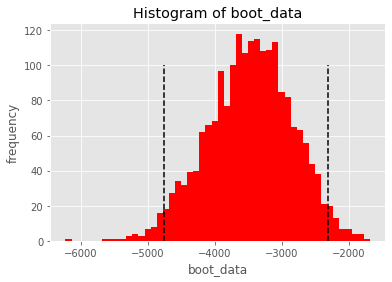

In [36]:
booted_data_1 = get_bootstrap(control_1.revenue, test.revenue, boot_it=2000) # тест А1/В

In [37]:
booted_data_1["p_value"]

4.257355019732455e-08

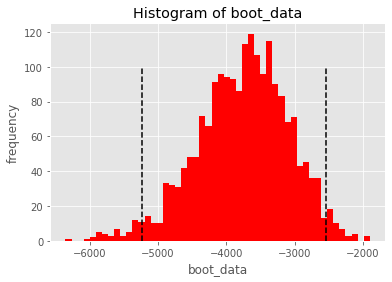

In [38]:
booted_data_2 = get_bootstrap(control_2.revenue, test.revenue, boot_it=2000) # тест А2/В

In [39]:
booted_data_2["p_value"]

2.0264446311280772e-08

###### Вывод -  обнаружена стат значимая разница (p-value < 0.05)

Следовательно, отвергаем нулевую гипотезу, отличия между суммами покупок в контрольной и тестовой группах статзначимо

# Вывод по итогам проведенного теста:
###  Поскольку задачей эксперимента ставилась цель увеличения выручки, то можно принять результаты в реализацию.


# Анализ по группам клиентов. Страны

In [43]:
all_group\
.groupby(['group', 'country'], as_index=False)\
.agg({'revenue':'sum'})\
.sort_values('revenue', ascending=False)\
.pivot(index='country', columns='group', values='revenue')\
.sort_values('country', ascending = False)

group,A1,A2,B
country,,,
United States of America,543101.0,562601.0,711360.0
United Kingdom (Great Britain),185523.0,96473.0,77376.0
United Arab Emirates,62296.0,22100.0,213785.0
Ukraine,NaN,8879.0,NaN
Turkey,16640.0,11700.0,9165.0
Switzerland,26572.0,28093.0,22256.0
Spain,82524.0,97422.0,285428.0
Portugal,19435.0,36894.0,NaN
Mexico,NaN,NaN,6214.0


In [44]:
all_group.query('country == "Ukraine"')

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,group
734,891995541.0,Ukraine,2017-10-23 08:05:00,2017-10-25 15:57:00,1261.0,19.0,empty_likes,coins,A2
792,891995541.0,Ukraine,2017-10-23 08:05:00,2017-10-23 10:02:00,6357.0,147.0,left_sidebar_menu,premium_no_trial,A2
806,891995541.0,Ukraine,2017-10-23 08:05:00,2017-10-26 09:37:00,1261.0,19.0,empty_likes,coins,A2


In [45]:
all_group.query('country == "Mexico"')

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,group
100,892275204.0,Mexico,2017-10-17 06:09:00,2017-10-17 15:05:00,6214.0,147.0,promo_09,premium_no_trial,B


In [46]:
all_group\
.groupby(['group', 'country'], as_index=False)\
.agg({'uid':'nunique'})\
.sort_values('uid', ascending=False)\
.pivot(index='country', columns='group', values='uid')\
.sort_values('country', ascending = False)

group,A1,A2,B
country,,,
United States of America,56.0,64.0,52.0
United Kingdom (Great Britain),9.0,10.0,8.0
United Arab Emirates,6.0,3.0,9.0
Ukraine,NaN,1.0,NaN
Turkey,2.0,1.0,1.0
Switzerland,3.0,3.0,3.0
Spain,8.0,10.0,15.0
Portugal,2.0,5.0,NaN
Mexico,NaN,NaN,1.0


Есть страны, где отсутствуют клиенты в одной или нескольких группах. Это Ukraine, Portugal, Mexico, Lithuania, Latvia, India, Austria. Кроме того, очень низкое, менее 10 клинетов  в двух группах отмечено в UK, Australia, Canada, Belgium, Germany, Chile, Israel, Switzerland, Turkey, Emirates. Такие группы будем исключать из рассмотрения.

Остается USA, Spain, Italy,  France, Argentina. Посмотрим ARPU в этих странах.


In [47]:
selected_countries = all_group.query('country == ["United States of America"\
,  "Spain", "Italy", "France", "Argentina"]')

In [48]:
metrics_sel = selected_countries\
    .groupby(['country','group'], as_index=False)\
    .agg({'revenue': ['size', 'count', 'sum', 'mean', 'min', 'max'], 'uid' : 'nunique'})\
    .round(0)
metrics_sel['ARPU'] = metrics_sel['revenue']['sum'].div(metrics_sel['uid']['nunique']).round(0)
metrics_sel[['country','group','ARPU']].pivot(index='country', columns='group', values='ARPU')\
.sort_values('country', ascending = False)

group,A1,A2,B
country,,,
United States of America,9698.0,8791.0,13680.0
Spain,10316.0,9742.0,19029.0
Italy,10191.0,6562.0,12603.0
France,7596.0,7362.0,22900.0
Argentina,11777.0,12102.0,26860.0


Проверим значения бутстрапом

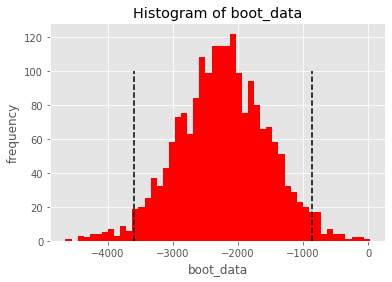

United States of America A1 0.0013072608091780917


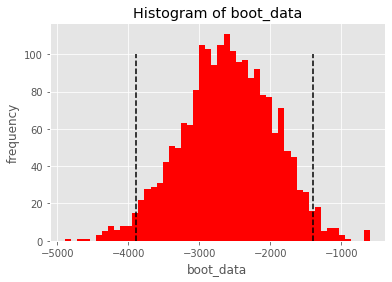

United States of America A2 5.670898269043195e-05


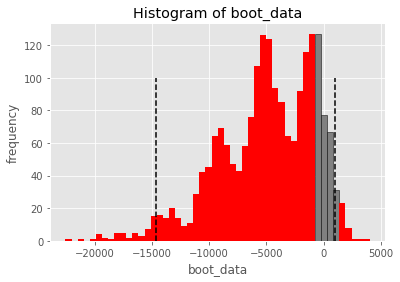

Spain A1 0.23814601085669262


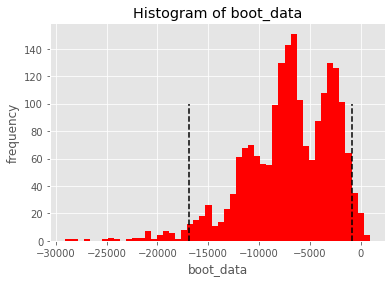

Spain A2 0.10766827848904283


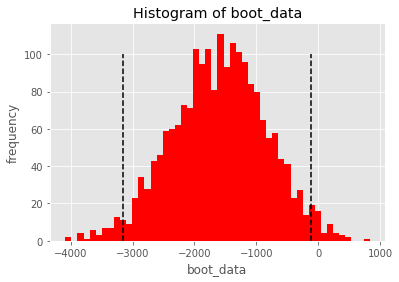

Italy A1 0.036064048042386755


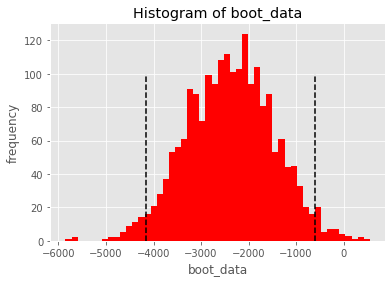

Italy A2 0.008816619506579158


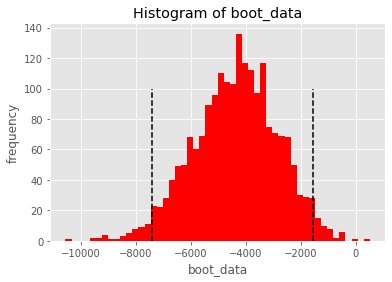

France A1 0.004289311591308823


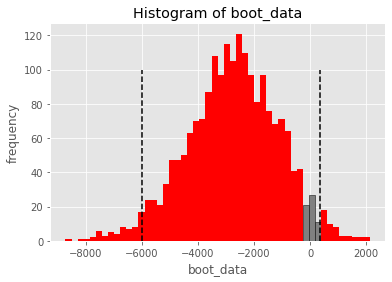

France A2 0.09120980059670845


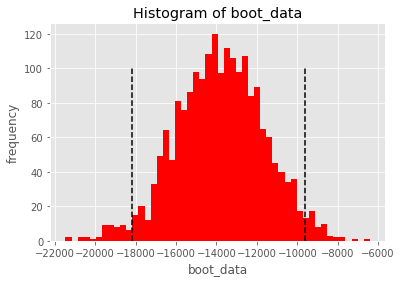

Argentina A1 1.9995796387966444e-10


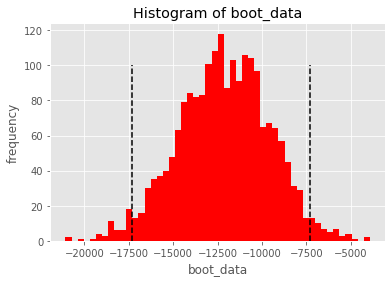

Argentina A2 1.8652761444977689e-06


In [49]:
country_list = ["United States of America", "Spain"\
                , "Italy",  "France", "Argentina"]
group_list = ["A1", "A2"]
bt = []
for c in country_list:
    for g in group_list:
        booted = get_bootstrap(all_group.query('country == @c and group == @g')\
                                .revenue, all_group.query('country == @c and group == "B"').\
                                revenue, boot_it=2000)
        print(c, g, booted["p_value"])
        bt.append(list([c, g, booted["p_value"]]))



### Только в USA, Italy, Argentina тестирование проходят успешно обе контрольные группы, в  France одна группа.НЕ прошла тестирование Spain.

In [50]:
df = pd.DataFrame(bt).rename(columns = {0:'country', 1:'group', 2 : 'p-value'}).\
                pivot(index='country', columns='group', values='p-value').round(5)

In [51]:
def highlight_pvalue(x):
    return ['background-color: mistyrose' if p >=0.05 else '' for p in x]

df.style.apply(highlight_pvalue)

group,A1,A2
country,,
Argentina,0.000000,0.000000
France,0.004290,0.091210
Italy,0.036060,0.008820
Spain,0.238150,0.107670
United States of America,0.001310,0.000060


# ВЫВОД. 
# Нововведение имеет смысл внедрять только в 3 странах - USA, Italy,  Argentina, и с осторожностью в France.